In [14]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os, time
import re
from astropy.io import fits
from astropy.wcs import WCS
from photutils import DAOStarFinder
from astropy.stats import mad_std
from photutils import aperture_photometry, CircularAperture
from astroquery.astrometry_net import AstrometryNet
from astroquery.exceptions import TimeoutError
from a345_utilities import print_header    

ast = AstrometryNet()
ast.API_URL = 'http://nova.astro.gla.ac.uk/api' 
ast.api_key = 'XXXXXXXX'
ast.URL = 'http://nova.astro.gla.ac.uk'



/var/folders/tn/fqh6631n3p56r504tcsqvss00000gn/T/ipykernel_64483/1686727451.py:8: DeprecationWarning: `photutils.DAOStarFinder` is a deprecated alias for `photutils.detection.DAOStarFinder` and will be removed in the future. Instead, please use `from photutils.detection import DAOStarFinder` to silence this warning.
  from photutils import DAOStarFinder
/var/folders/tn/fqh6631n3p56r504tcsqvss00000gn/T/ipykernel_64483/1686727451.py:10: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import aperture_photometry, CircularAperture
/var/folders/tn/fqh6631n3p56r504tcsqvss00000gn/T/ipykernel_64483/1686727451.py:10: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please 

['Year_3', '.Spotlight-V100', '.DS_Store', 'images', 'calibration', 'W UMa', 'TZ_Aur', 'calibrated_images', 'platesolved_img', '.Trashes', 'Variable Star', 'V403 Gem', '.fseventsd', '.git']
['Chr R', 'Chr G', 'CHr I']
38963.10313180551
39188.132325294624
25066.499098423286


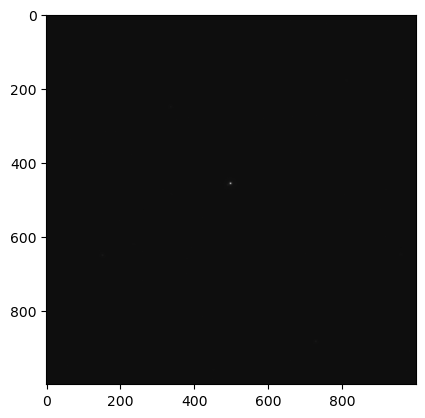

In [25]:
cal_path = '/Volumes/external_2T/calibration/2023-10/neg10c/master/'
data_path = '/Volumes/external_2T/'

flat_dark = fits.open(cal_path + 'dark_flat_gr_3s_master.fits')[0].data #Flat dark same for all images

exposure = '10s'      #Define the exposure of the images to calibrate
star_name = 'W UMa'      # Define star name

flat_i = fits.open(cal_path + 'flat_i_master.fits')[0].data
flat_g = fits.open(cal_path + 'flat_g_master.fits')[0].data
flat_r = fits.open(cal_path + 'flat_r_master.fits')[0].data

stars = os.listdir(data_path)
print(stars)
for star in stars:
    if re.search(star_name, star):

        col_band = os.listdir(data_path + star)
        
        col_band = col_band[1:]
            
        print(col_band)
        for band in col_band:
            
            if band.endswith('I'):
                flat = flat_i
            elif band.endswith('G'):
                flat = flat_g
            elif band.endswith('R'):
                flat = flat_r

            avg_flat_dark = np.mean((flat-flat_dark))
            print(avg_flat_dark)
            files = os.listdir(data_path + star + '/' + band)
            for file in files:

                if re.search(exposure ,file):
                    dark = fits.open(cal_path + 'dark_' + exposure + '_master.fits')[0].data

                if file.endswith('.fits'):
                    science = fits.open(data_path + star + '/' + band + '/' + file)[0].data
                    header = fits.open(data_path + star + '/' + band + '/' + file)[0].header
                    cali_img = (science - dark) * (avg_flat_dark/(flat - flat_dark))

                    plt.imshow(cali_img)
                    plt.set_cmap('gray')
                    
                    hdu = fits.PrimaryHDU(cali_img)
                    hdu.header.update(header)
                    hdu.writeto(data_path + 'calibrated_images/' + star + '/' + band + '/' + '_calibrated_' + file, overwrite = True)


In [32]:
for star in stars:
    if re.search(star_name, star):
        col_band = os.listdir(data_path + star)
        
        col_band = col_band[1:]
        for band in col_band:
            files = os.listdir(data_path + star + '/' + band)
            for file in files:
                if file.endswith('.fits'):
                    data = fits.open(data_path + star + '/' + band + '/' + file)[0].data
                    header = fits.open(data_path + star + '/' + band + '/' + file)[0].header


                    d_mean = np.mean(data);    
                    d_std  = np.std(data);     
                    vmin = d_mean - d_std/2     
                    vmax = d_mean + d_std   


                    bkg_sigma = mad_std(data)                                    
                    daofind = DAOStarFinder(fwhm=6, threshold=20*bkg_sigma)    

                    sources = daofind(data)  
                    for col in sources.colnames:  
                        sources[col].info.format = '%.6g' 


                    sources.sort('flux') 
                    sources.reverse()   
                    sources  


                    image_width, image_height = data.shape
                    wcs_header = None           
                    t_start = time.time()
                    try:
                        print('Sending data to AstrometryNet server:')
                        wcs_header = ast.solve_from_source_list(sources['xcentroid'], sources['ycentroid'],
                                                                image_width, image_height,
                                                                solve_timeout=30000)
                        if wcs_header:   
                            print('\n -> Success. Solving took {:0.1f}s'.format(time.time()-t_start))
                            # print_header(wcs_header)        
                        else:
                            print('\n -> Solving failed after {:0.1f}s'.format(time.time()-t_start))   
                    except TimeoutError:       
                        print('\n -> ##FAIL: Timeout while solving, try a longer timeout, optmise number of sources (200-800 seems about right)')

                    header.update(wcs_header) 

                    wcs = WCS(wcs_header)

                    print(wcs.get_axis_types())

                    plt.figure(figsize=(10,18))
                    plt.subplot(projection=wcs[0])
                    #get some colour limits
                    mean_intensity = np.mean(data)
                    r = 200
                    plt.imshow(data,vmin=mean_intensity, vmax = mean_intensity+r, cmap='gray')    
                    plt.grid(color='lightblue', ls='solid')    

                    # flip the y-axis to get dec increasing to the top
                    plt.gca().invert_yaxis()
                    plt.show()

                    hdu = fits.PrimaryHDU(data)         # create a FITS HDU object
                    hdu.header = header
                    hdu.header.update(wcs_header)       # add in the header containg the wcs data
                    hdu.writeto(data_path + 'platesolved_img/' + star + '/' + band + '/' + '_platesolved_' + file, overwrite = True)

                    break

Sending data to AstrometryNet server:
Solving.....
 -> Success. Solving took 5.4s
[{'coordinate_type': 'celestial', 'scale': 'non-linear celestial', 'group': 0, 'number': 0}, {'coordinate_type': 'celestial', 'scale': 'non-linear celestial', 'group': 0, 'number': 1}]


TypeError: WCSAxes.__init__() got multiple values for argument 'wcs'

<Figure size 1000x1800 with 0 Axes>

In [ ]:
# cali = fits.open(data_path + 'calibrated_images/' + star + '/' + band + '/' + '_calibrated_')[0].data
# plate = 

# plt.figure(figsize = (10,10))
# plt.imshow